In [1]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

In [6]:
# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
#from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, MaxPool2D


In [7]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((6, 6)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((6, 6)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

In [8]:
def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)
    


In [9]:
def scale_to_range(image):
    return image/255

In [10]:
def matrix_to_vector(image):
    return image.flatten()

In [11]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

In [12]:
def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [13]:
def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

In [14]:
def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

In [15]:
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [16]:
def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [18]:
from sklearn.cluster import KMeans


In [19]:
def select_roi_with_distances(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    regions_array = []
    print(len(contours))
    #print(hierarchy)
    #for contour in contours:
    for i in range(0, len(contours)):
        center1, size1, angle1 = cv2.minAreaRect(contours[i])
        width1, height1 = size1
        if hierarchy[0][i][3] == 0:
            x, y, w, h = cv2.boundingRect(contours[i])
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # izdvojiti sortirane parametre opisujucih pravougaonika
    # izracunati rastojanja izmedju svih susednih regiona po X osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
        region_distances.append(distance)
    
    return image_orig, sorted_regions, region_distances, contours

In [20]:
def display_result_with_spaces(outputs, alphabet, k_means):
    # odredjivanje indeksa grupe koja odgovara rastojanju izmedju reci
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]
    #print(max(enumerate(k_means.cluster_centers_), key=lambda x: x[1]))
    #print(k_means.cluster_centers_)
    #print(k_means.labels_)
    result = alphabet[winner(outputs[0])]
    # iterativno dodavanje prepoznatih elemenata
    # dodavanje space karaktera ako je rastojanje izmedju dva slova odgovara rastojanju izmedju reci
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

99
Broj prepoznatih regiona:  71


array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255,   0,   0]],

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255,   0,   0]],

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

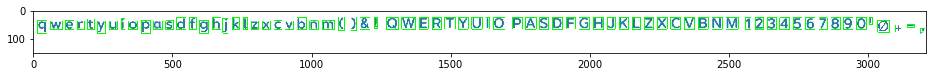

In [21]:
def image_grayy(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_binn(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    #ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

image_color = load_image('C:\\Users\Korisnik\PycharmProjects\SoftComputing\projekat\songpop_text\\all.jpg')
img = image_binn(image_grayy(image_color))
img_bin = erode(img)
#plt.imshow(img)
selected_regions, letters, region_distances, contours = select_roi_with_distances(image_color.copy(), img_bin)
print("Broj prepoznatih regiona: ", len(letters))
display_image(selected_regions)

imgg = selected_regions.copy()
cv2.drawContours(imgg, contours, -1, (255, 0, 0), 1)
#plt.imshow(imgg, 'gray')

In [22]:
#alphabet = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.', ',', '-', '!', '?', 'q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p',
#            'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm',
#            'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L',
#            'Z', 'X', 'C', 'V', 'B', 'N', 'M']
#alphabet = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p',
#            'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm',
#            'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L',
#            'Z', 'X', 'C', 'V', 'B', 'N', 'M'
#            ]
alphabet = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p',
            'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm', '(', ')', '&', '!'
            ]   
alphabet = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p',
            'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm', '(', ')', '&', '!',
            'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L',
            'Z', 'X', 'C', 'V', 'B', 'N', 'M',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'
            ]  
alphabet = [
            'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L',
            'Z', 'X', 'C', 'V', 'B', 'N', 'M',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'
            ]  
alphabet = [
            'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'A', 'S', 'D', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'
            ] 
alphabet = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p',
            'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z', 'x', 'c', 'v', 'b', 'n', 'm', '(', ')', '&', '!',
            'Q', 'W', 'E', 'R', 'T', 'Y', 'A', 'D', 'F', 'G', 'H', 'L',
            'B', 'N', 'M',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'
            ] 
alphabet = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p',
            'a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'z',
            'x', 'c', 'v', 'b', 'n', 'm', '(', ')', '&', '!',
            'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P',
            'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'Z',
            'X', 'C', 'V', 'B', 'N', 'M',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '0',
            '\'', 'Ø', '+', '-', ','
            ]
print(len(alphabet))
inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
ann = create_ann(output_size=55)
ann = train_ann(ann, inputs, outputs, epochs=2000)


71

Training started...


ValueError: Error when checking target: expected dense_2 to have shape (55,) but got array with shape (71,)

99
Broj prepoznatih regiona:  71


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

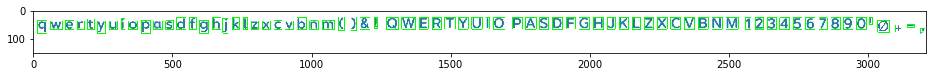

In [23]:
image_color = load_image('C:\\Users\Korisnik\PycharmProjects\SoftComputing\projekat\songpop_text\\all.jpg')


img = image_bin(image_gray(image_color))
selected_regions, letters, distances, contours = select_roi_with_distances(image_color.copy(), erode(img))
print("Broj prepoznatih regiona: ", len(letters))
display_image(selected_regions)

# neophodno je da u K-Means algoritam bude prosledjena matrica u kojoj vrste odredjuju elemente
distances = np.array(distances).reshape(len(distances), 1)

k_means = KMeans(n_clusters=2)
k_means.fit(distances)



In [177]:
inputs = prepare_for_ann(letters)
results = ann.predict(np.array(inputs, np.float32))
print(display_result_with_spaces(results, alphabet, k_means))


qwertyuiopcsdfghjklzxcvbnm( )&! QWERTYADFGHLBNM 1234567890


14
Broj prepoznatih regiona:  8
klo DGnce
21
Broj prepoznatih regiona:  14
1 e 6 D0e 273 e 8 2 5 5
15
Broj prepoznatih regiona:  9
Godis plDn
10
Broj prepoznatih regiona:  8
Thls is Me
0.3076923076923077 Thls is Me


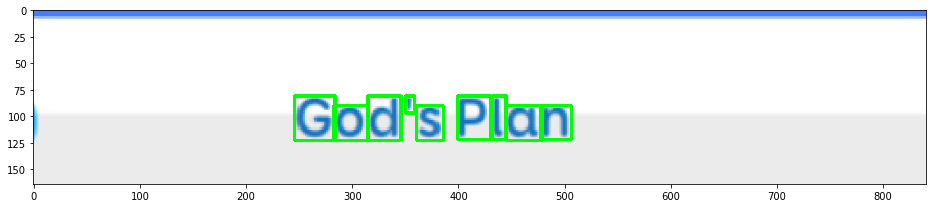

In [178]:
import pyautogui
import time

time.sleep(2)
imm = pyautogui.screenshot()
#plt.imshow(im)
imm.save('C:\\Users\Korisnik\PycharmProjects\proj\songpop_text\screen1.png')

dims = [[690, 780, 490, 950], [690, 780, 1020, 1480], [800, 890, 490, 950], [800, 890, 1020, 1480]]
X = []
answers = []
#im = load_image('C:\\Users\Korisnik\PycharmProjects\proj\songpop_text\screenshot5.jpg')
im = load_image('C:\\Users\Korisnik\PycharmProjects\proj\songpop_text\screen1.png')
for i in range(4):
    X.append(im[dims[i][0]:dims[i][1],dims[i][2]:dims[i][3]].copy())
    #display_image(X[i])
    
    scale_percent = 182.95 # percent of original size
    width = int(X[i].shape[1] * scale_percent / 100)
    height = int(X[i].shape[0] * scale_percent / 100)
    dim = (width, height)
      
    # resize image
    resized = cv2.resize(X[i], dim, interpolation = cv2.INTER_AREA)
    #display_image(resized)
    
    eh = image_bin(image_gray(resized))
    selected_regions1, letters1, distances1, contours1 = select_roi_with_distances(resized.copy(), erode(eh))
    print("Broj prepoznatih regiona: ", len(letters1))
    if i==2: display_image(selected_regions1)
    
    # neophodno je da u K-Means algoritam bude prosledjena matrica u kojoj vrste odredjuju elemente
    distances1 = np.array(distances1).reshape(len(distances1), 1)
    
    k_means = KMeans(n_clusters=2)
    k_means.fit(distances1)

    inputs1 = prepare_for_ann(letters1)
    results1 = ann.predict(np.array(inputs1, np.float32))
    print(display_result_with_spaces(results1, alphabet, k_means))
    answers.append(display_result_with_spaces(results1, alphabet, k_means))

result, resultText, index = get_most_similar("Me!", answers)
print(result, resultText)
pyautogui.moveTo(dims[index][2]+10, dims[index][0]+10)
pyautogui.click()

In [25]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


In [26]:
print(similar("Ellie Goulding","r l l l e g o u l d li n g"))
print(similar("Ellie Goulding","o av e"))
print(similar("Ellie Goulding","h e a sl ah so ewt mt l ea nl zf nh see om rbe l ae t e s t"))
print(similar("Ellie Goulding","post malone l swae bee"))



0.3
0.1
0.136986301369863
0.2222222222222222


In [27]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def get_most_similar(correct, answers):
    max = similar(correct, answers[0])
    maxText = answers[0]
    index = 0
    for i in range(1,4):
        current = similar(correct, answers[i])
        if current > max:
            max = current
            maxText = answers[i]
            index = i
    return max, maxText, index
    

In [28]:
#dva reda
#()'!
#slova i i j
#velika slova

